Hunter Bennett | Glass Lab | Kupffer Strains Project | 13 April 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [2]:
dataDirectory = '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/'
workingDirectory = '/home/h1bennet/strains/results/08_obob_Leptin_6h_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# We will start by using O'young's script to get the IDR peaks for each condition
____
We already made these for the QC notebook!  

The output of peakIDR.R includes many things, the main thing we use are the final .idr peak files for each group


# Run peakIDR.R

    source activate r-ouyangPipe
    
    mkdir ./quantification
    
    mkdir ./differential
        
    peakIDR.R ./sampleDef.txt
    
    peakQuan.R ./sampleDef.txt -out ./quantification/ -g mm10 -a atac -i ./peakIDR_tmp/ -c -size 200 -pc 0
    

In [3]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi
# # move IDR peaks into atac_peak_folder
# mv *kupffer*.idr ./atac_peak_files

### convert to bed files

    mkdir ./atac_bed_files
    pos2bed.pl -o ./atac_bed_files/obob_leptin_kupffer.idr.bed \
    -track "obob leptin 6h IDR peaks" ./atac_peak_files/obob_leptin_kupffer.idr
    
    pos2bed.pl -o ./atac_bed_files/obob_pbs_kupffer.idr.bed \
    -track "obob pbs 6h IDR peaks" ./atac_peak_files/obob_pbs_kupffer.idr

### Merge peaks

In [4]:
if not os.path.isdir('./merged_peaks/'):
    os.mkdir('./merged_peaks/')

In [5]:
with open('./mergePeaks_homer.sh', 'w') as f:
    peakfiles = np.sort(glob.glob('./atac_peak_files/*idr'))
    merge_peaks = ['mergePeaks', '-d', 'given',
                   ' '.join(peakfiles), '>',
                   './merged_peaks/idr_peaks_merged.txt', '\n']
    f.write(' '.join(merge_peaks))    
f.close()

# Annotate peaks

In [6]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob(dataDirectory+'*'))

drop_files = ['00_NCoRWT_Kupffer_ATAC_control_young_LN12aM_JSS_150812',
              '00_NCoRWT_Kupffer_ATAC_control_young_NNaF_JSS_150811']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [7]:
tagdirs

['/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L3_TDT_s20210428_ACTCGCTA_GTAAGGAG',
 '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L5_TDT_s20210428_GCGTAGTA_AAGGAGTA',
 '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L8_TDT_s20210428_ATGCGCAG_TCTCTCCG',
 '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P4_TDT_s20210428_GGAGCTAC_ACTGCATA',
 '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P6_TDT_s20210428_CGGAGCCT_CTAAGCCT',
 '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/obob_leptin/mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P7_TDT_s20210428_TACGCTGC_CGTCTAAT']

Create script to annotate peaks with HOMER - its possible that this is resizing the peaks and thats why downstream we dont have to do anything

In [8]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_raw_idr_peaks_merged.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_norm_idr_peaks_merged.txt &\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Summary plots

In [9]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [10]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_peaks_merged.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks

In [12]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1,2], [3,4,5]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

154196 total peaks
filtering low tag count peaks
112425 total peaks


### Mean variance plot

In [14]:
mat_quant.columns

Index(['mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L3_TDT_s20210428_ACTCGCTA_GTAAGGAG',
       'mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L5_TDT_s20210428_GCGTAGTA_AAGGAGTA',
       'mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L8_TDT_s20210428_ATGCGCAG_TCTCTCCG',
       'mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P4_TDT_s20210428_GGAGCTAC_ACTGCATA',
       'mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P6_TDT_s20210428_CGGAGCCT_CTAAGCCT',
       'mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_20210428P7_TDT_s20210428_TACGCTGC_CGTCTAAT'],
      dtype='object')

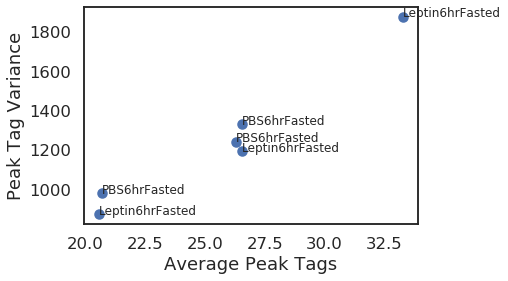

In [15]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[5],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

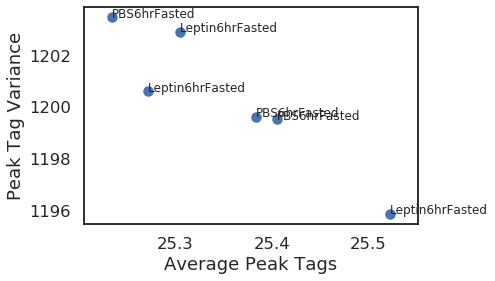

In [16]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[5],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Scatter plot

In [17]:
# g = sns.PairGrid(np.log2(mat+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter.png', bbox_inches='tight')

In [18]:
# g = sns.PairGrid(np.log2(mat_quant+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

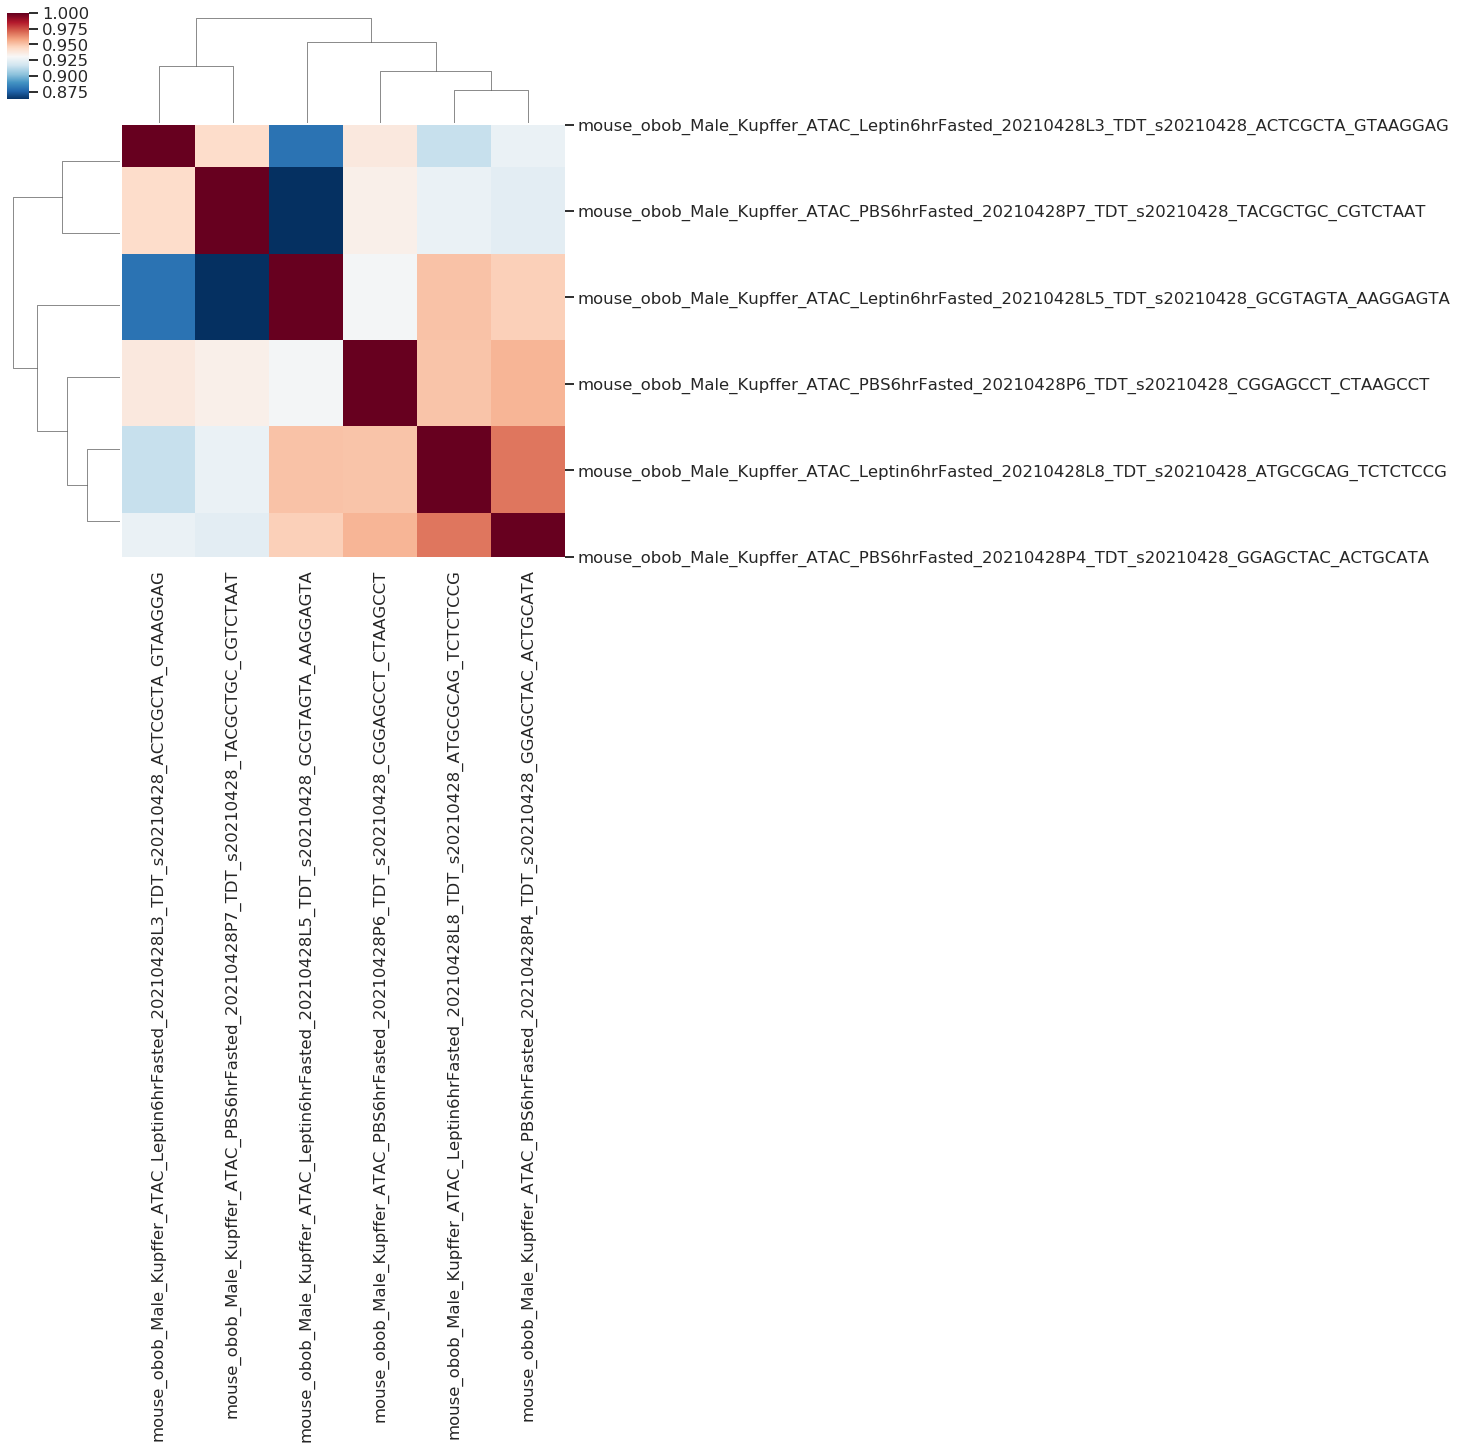

In [19]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap.png', bbox_inches='tight')

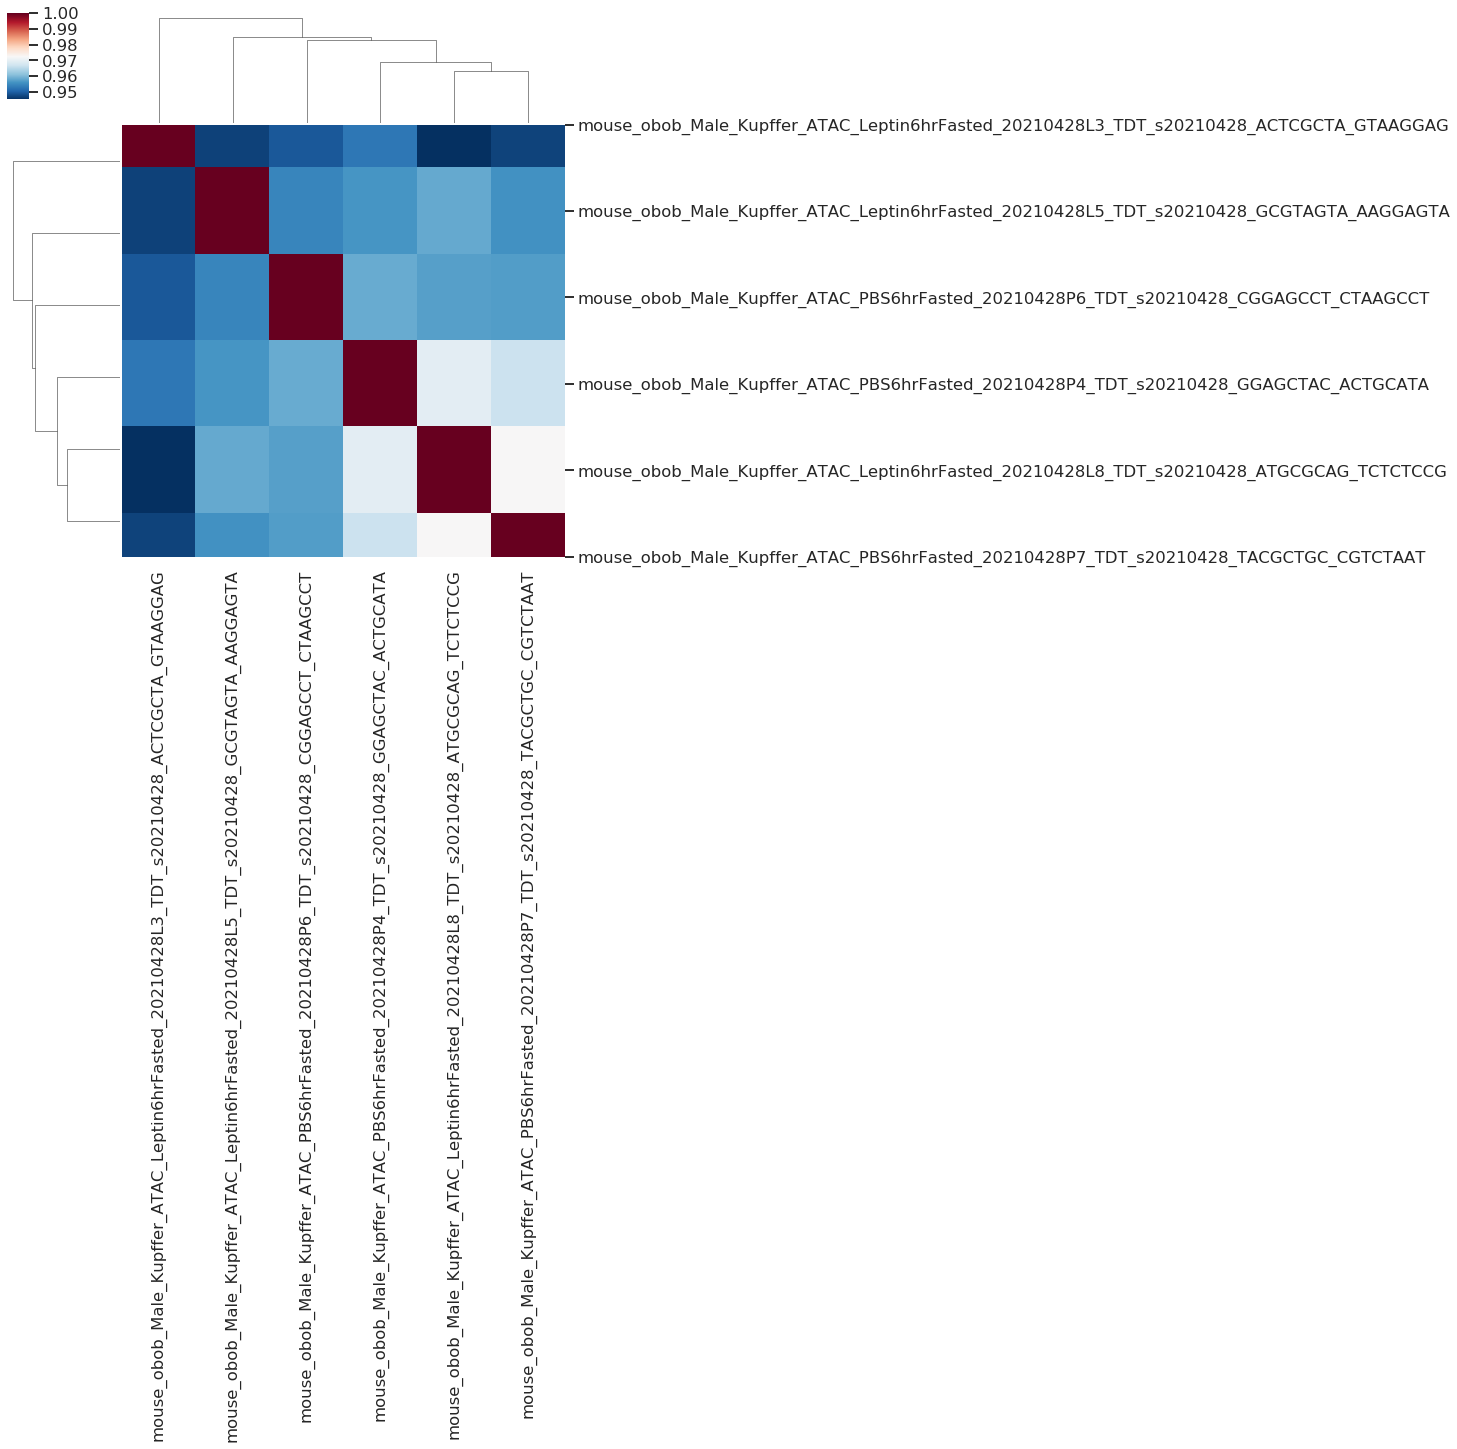

In [20]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

In [21]:
mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

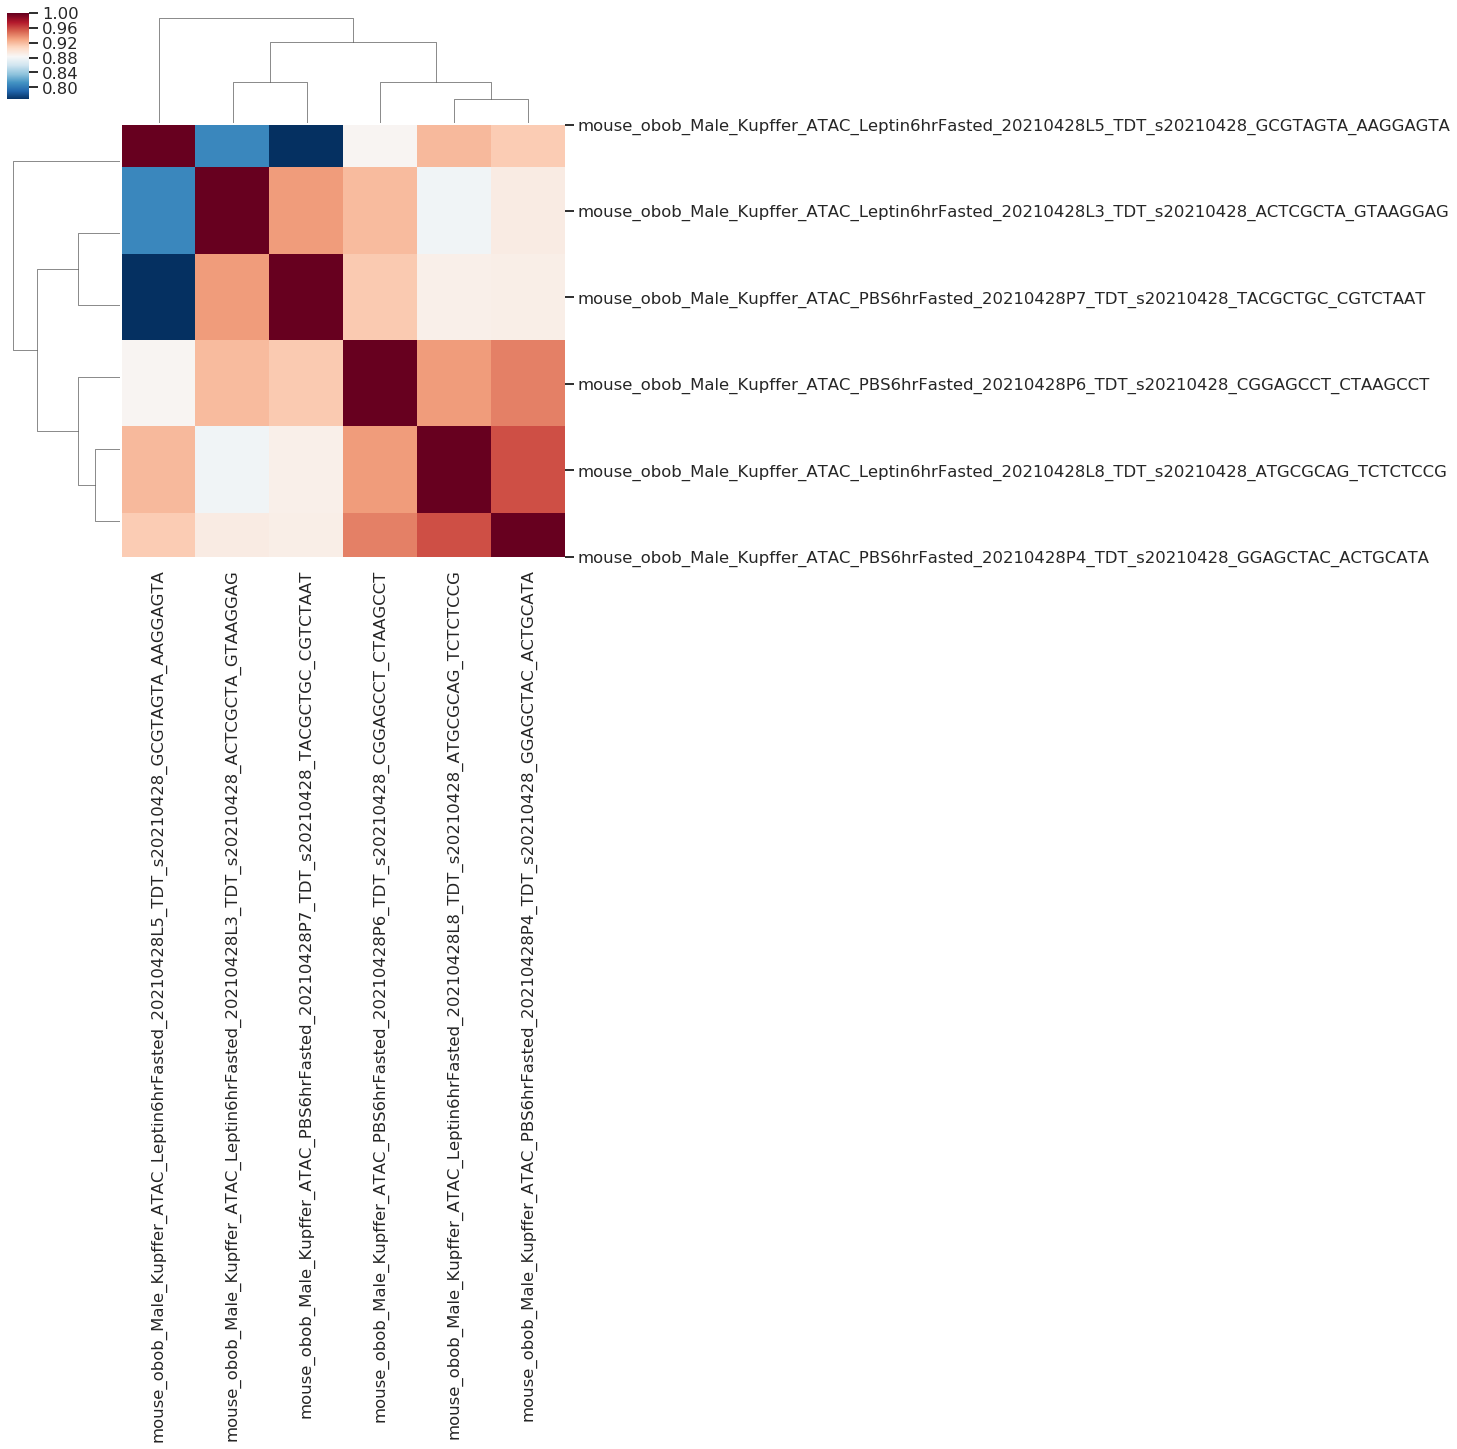

In [23]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [27]:
samples[0]

'mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_20210428L3_TDT_s20210428_ACTCGCTA_GTAAGGAG'

In [32]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[3]
treatment = samples.str.split('_').str[5]
treatment_time = samples.str.split('_').str[7]
mouseid = samples.str.split('_').str[6]
sampledate = samples.str.split('_').str[8]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

In [33]:
samplesDF

,mouse,group,strain,celltype,treatment,treatment_time,mouse_id,sample_date
0,mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_2...,mouse,obob,Kupffer,Leptin6hrFasted,TDT,20210428L3,s20210428
1,mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_2...,mouse,obob,Kupffer,Leptin6hrFasted,TDT,20210428L5,s20210428
2,mouse_obob_Male_Kupffer_ATAC_Leptin6hrFasted_2...,mouse,obob,Kupffer,Leptin6hrFasted,TDT,20210428L8,s20210428
3,mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_2021...,mouse,obob,Kupffer,PBS6hrFasted,TDT,20210428P4,s20210428
4,mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_2021...,mouse,obob,Kupffer,PBS6hrFasted,TDT,20210428P6,s20210428
5,mouse_obob_Male_Kupffer_ATAC_PBS6hrFasted_2021...,mouse,obob,Kupffer,PBS6hrFasted,TDT,20210428P7,s20210428


### Look at PCA plots for all the samples

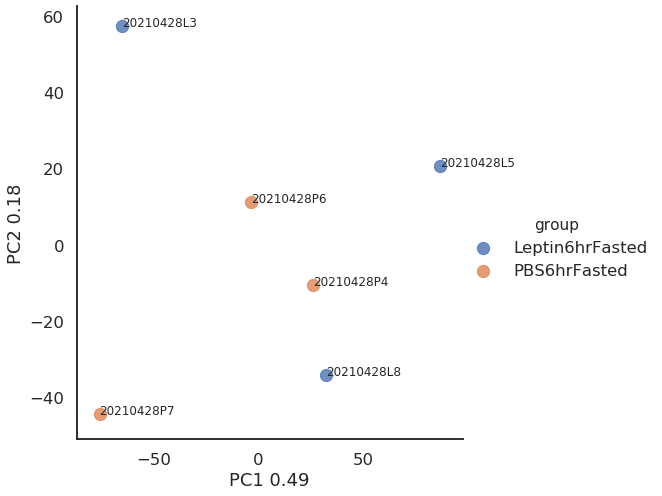

In [35]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2.png', bbox_inches='tight')

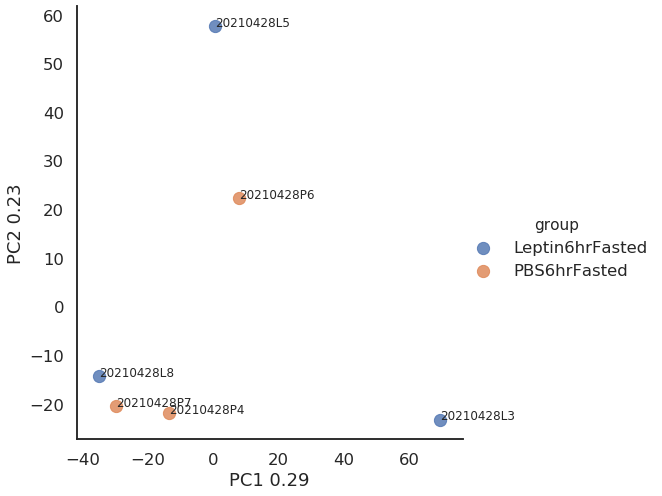

In [39]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2_quantnorm.png', bbox_inches='tight')

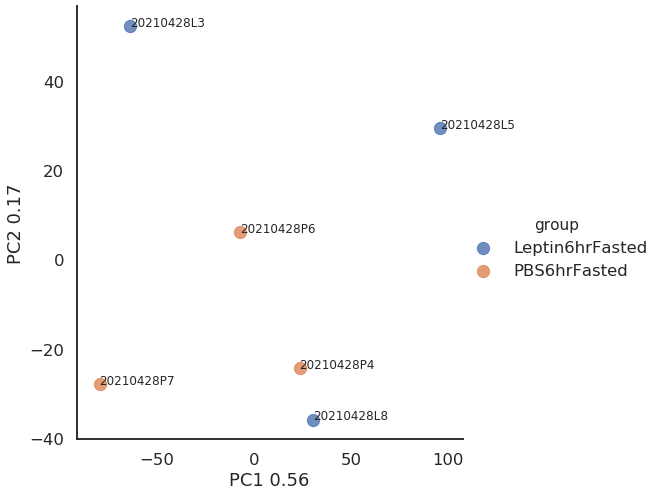

In [40]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_distal_pca1_pca2.png', bbox_inches='tight')

BALB4 has way more reads than the rest of the samples... in this case it has been normalized and looks fine compared to all the other samples. Not sure how this will effect differential peak calling...

# Make Venn Diagram of Active Enhancers

In [32]:
from matplotlib_venn import venn3

In [33]:
groups = ['AJ', 'BALBcJ', 'C57Bl6J']
columns = [[0,1,2,3],
           [4,5,6,7],
           [8,9,10,11]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [34]:
thresh=16

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

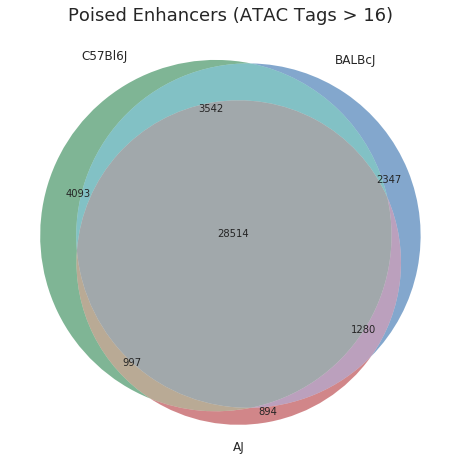

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn.venn3(subsets=[set(peak_dict['C57Bl6J']),
               set(peak_dict['BALBcJ']),
               set(peak_dict['AJ'])],
      set_colors=('#006d2c', '#08519c', '#a50f15'),
      set_labels=('C57Bl6J', 'BALBcJ', 'AJ'),
      alpha=0.5,
      ax=ax)
ax.set_title('Poised Enhancers (ATAC Tags > %d)' % thresh);

plt.savefig('./figures/venn3_poised_ATAC_peaks.png', bbox_inches='tight')

# Write 'poised' enhancers out for analysis with HOMER
___
Should use the same threshold as venn diagram above

In [36]:
if not os.path.isdir('./poised_enhancers/'):
    os.mkdir('./poised_enhancers/')

Select distal peaks

In [37]:
df_distal = df.loc[np.abs(df['Distance to TSS']) > 3*10**3, :]

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [38]:
convert_dict = {'Start': int,
                'End': int}

In [39]:
for col in avg_tags_df.columns:
    tmp = df.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./poised_enhancers/'+col+'_poised_enhancer_peaks.txt', sep='\t')
    
    tmp = df_distal.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./poised_enhancers/'+col+'_poised_distal_enhancer_peaks.txt', sep='\t')

# Optional: Repeat analysis with outliers dropped

In [40]:
# # import annotation file
# df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_peaks_merged.txt')

# # try with dropped sample
# dropsamp = ['/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control/01_balbc_Kupffer_ATAC_control_young_balb10B_TDT_JSS_20161013']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# # shorten columns to make labeling nicer
# mat.columns = mat.columns.str.split('/').str[-1]

# # quantile normalize data
# mat_quant = quantile_normalize_df(mat)

In [41]:
# cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
# plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# plt.savefig('./figures/atac_correlation_heatmap_outliers_dropped.png', bbox_inches='tight')

In [42]:
# cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
# plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# plt.savefig('./figures/atac_correlation_heatmap_quantnorm_outliers_dropped.png', bbox_inches='tight')

In [43]:
# mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
# mat_distal.dropna(inplace=True)

In [44]:
# cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
# plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# plt.savefig('./figures/atac_correlation_distal_heatmap_outliers_dropped.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [45]:
# # this part must be done manually - use the sample ID fields to pick out
# # identifiers for each sample.
# samples = pd.Series(mat.columns.str.split('/').str[-1])
# group = samples.str.split('_').str[0]
# strain = samples.str.split('_').str[1]
# cell = samples.str.split('_').str[2]
# treatment = samples.str.split('_').str[4]
# treatment_time = samples.str.split('_').str[5]
# mouseid = samples.str.split('_').str[6]
# sampledate = samples.str.split('_').str[-1]
                                        
# samplesDF = pd.DataFrame([pd.Series(samples),
#                           pd.Series(group),
#                           pd.Series(strain),
#                           pd.Series(cell),
#                           pd.Series(treatment),
#                           pd.Series(treatment_time),
#                           pd.Series(mouseid),
#                           pd.Series(sampledate)],
#                          index=['mouse', 'group', 'strain', 'celltype',
#                                 'treatment', 'treatment_time', 'mouse_id',
#                                 'sample_date']).T

### PCA - outliers removed

In [46]:
# pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
#                                  group_labels=samplesDF.group,
#                                  plot_size=7,
#                                  n_pca=3)

# label_point(pca.PC1,
#             pcaa.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

# plt.savefig('./figures/atac_pca1_pca2_outliers_dropped.png', bbox_inches='tight')

In [47]:
# pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
#                                  group_labels=samplesDF.group,
#                                  plot_size=7,
#                                  n_pca=3)
# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

# plt.savefig('./figures/atac_pca1_pca2_quantnorm_outliers_dropped.png', bbox_inches='tight')

In [48]:
# pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
#                                  group_labels=samplesDF.group,
#                                  plot_size=7,
#                                  n_pca=3)

# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

# plt.savefig('./figures/atac_distal_pca1_pca2_outliers_dropped.png', bbox_inches='tight')

# Once we have settled on tag directories for each group we will make merged tag directories for visualization in the genome browser

In [49]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob(dataDirectory+'*'))

drop_files = ['00_NCoRWT_Kupffer_ATAC_control_young_LN12aM_JSS_150812',
              '00_NCoRWT_Kupffer_ATAC_control_young_NNaF_JSS_150811']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [50]:
# might have to adjust this depending on the sample ids
groups = ['aj', 'balbcj', 'c57bl6j']

In [51]:
with open('./merge_tagdirs.sh', 'w') as f:
    for group in groups:
        tagdirs_to_merge = [i for i in tagdirs if group in i]
        merge_call = ['makeTagDirectory',
                      './merged_tagdirs/'+group+'_Kupffer_ATAC_young_control',
                      '-d \\\n', ' \\\n'.join(tagdirs_to_merge), '\n\n']
        f.write(' '.join(merge_call))
    f.close()

### write command for upload as browser hub

In [52]:
!ls merged_tagdirs

aj_Kupffer_ATAC_young_control	   c57bl6j_Kupffer_ATAC_young_control
balbcj_Kupffer_ATAC_young_control


Colors chosen as second color from 3 class green, blue, and red on colorbrewer2.org

    makeMultiWigHub.pl hrb_strains_viz_atac_merged_young_control_cohort2 mm10 \
    -color 222,45,38 49,130,189 49,163,84 \
    -force -d \
    ./merged_tagdirs/aj_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/balbcj_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/c57bl6j_Kupffer_ATAC_young_control/